<a href="https://colab.research.google.com/github/BigRedEye/co-project/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы для ускорения невыпуклой оптимизации
## Выполнили: студенты группы 175 Родионов Антон и Скорцов Сергей

В данной работе были реализованы следующие методы оптимизации:
1. SGD
2. Polyak Momentum
3. Nesterov Momentum
4. New Nesterov Momentum

А так же некоторые их аналоги с адаптивным выбором шага:
1. Adam
2. Nadam

Для проверки работы использовались следующие сети:
1. LogisticRegression
2. Two-layer Fully-connected network
3. Simple Convolutional network
4. SqueezeNet v1.1

Все модели обучались на датасете CIFAR10 на протяжении 5 эпох.
В результате работы производится сравнение этих методов при различных значениях batch_size, momentum и learning rate.

Более полные результаты будут выложены чуть позже


### Logistic regression


In [0]:
import torch
from torchsummary import summary

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear(x)
        return outputs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = LogisticRegression(32 * 32 * 3, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
None


### Two-layer FC network

In [0]:
import torch
from torchsummary import summary

class FullyConnected(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnected, self).__init__()
        self.l1 = torch.nn.Linear(input_dim, hidden_dim)
        self.l2 = torch.nn.Linear(hidden_dim, output_dim)
        self.flatten = torch.nn.Flatten()
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = FullyConnected(32 * 32 * 3, 128, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 128]         393,344
           Sigmoid-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
           Sigmoid-5                   [-1, 10]               0
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 1.51
Estimated Total Size (MB): 1.54
----------------------------------------------------------------
None


### Small ConvNet

In [0]:
import torch
import torch.nn
from torchsummary import summary

class ConvNet(torch.nn.Module):
    def __init__(self, in_ch, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_ch, 32, kernel_size=5, stride=1, padding=2)
        self.relu = torch.nn.LeakyReLU()
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.drop_out = torch.nn.Dropout()
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.conv5 = torch.nn.Conv2d(128, output_dim, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drop_out(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.gap(x)
        return torch.flatten(x, 1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNet(3, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
         LeakyReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          25,632
         LeakyReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          51,264
         LeakyReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         204,928
        LeakyReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
          Dropout-13            [-1, 128, 2, 2]               0
           Conv2d-14             [-1, 1

### SqueezeNet(Implemented in Pytorch)

In [0]:
from torchvision.models import squeezenet1_1 as SqueezeNet
from torchsummary import summary

net = SqueezeNet().to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           1,792
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 16, 7, 7]           1,040
              ReLU-5             [-1, 16, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]           1,088
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]           9,280
              ReLU-9             [-1, 64, 7, 7]               0
             Fire-10            [-1, 128, 7, 7]               0
           Conv2d-11             [-1, 16, 7, 7]           2,064
             ReLU-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]           1,088
             ReLU-14             [-1, 6

### SGD + Momentum + Nesterov momentum

In [0]:
import torch

class SGDOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0, nesterov=0, eps=1e-6, **kwargs):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum parameter: {} - should be >= 0.0".format(momentum))
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, eps=eps)
        super(SGDOptimizer, self).__init__(params, defaults)
    
    def step1(self, criterion, inputs, labels ,closure = None):
        return self.step()
    
    @torch.no_grad()
    def step(self, closure=None):
        loss = None

        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                #grad = p.grad.data
                #if grad.is_sparse:
                #    raise RuntimeError("Optimizer does not support sparse gradients, please consider SparseOptimizer instead")
                momentum = group["momentum"]
                nesterov = group["nesterov"]
                lr = group["lr"]

                state = self.state[p]
                buffer = p.grad
                if momentum != 0:
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.clone(p.grad).detach()
                    buffer = state["momentum_buffer"]
                    if nesterov:
                        #https://arxiv.org/pdf/1212.0901v2.pdf or https://cs231n.github.io/neural-networks-3/#sgd
                        buffer_prev = buffer.clone().detach()

                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer_prev, alpha=-momentum).sub_(buffer, alpha=1+momentum)
                    else:
                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer, alpha=-1)
                else:
                    p.add_(buffer, alpha=-lr)
        return loss

### New Nesterov Momentum

In [0]:
import torch
import copy

class NewNesterovOptimizer(torch.optim.Optimizer):
    def __init__(self, params, net, lr=1e-3, eps=1e-6, **kwargs):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        defaults = dict(lr=lr, eps=eps, net=net)
        super(NewNesterovOptimizer, self).__init__(params, defaults)

    def step1(self, criterion, inputs, labels, closure = None):
        for group in self.param_groups:
            group["criterion"] = criterion
            group["inputs"] = inputs
            group["labels"] = labels
        return self.step()
    
    def step(self, closure=None):
        loss = None

        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            tau = torch.zeros(100);
            net = group["net"]
            net_params = net.parameters()

            criterion = group["criterion"]
            inputs = group["inputs"]
            labels = group["labels"]
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    np.data = copy.deepcopy(p.data)
            
            for np in net.parameters():
                if np.grad is None:
                    continue
                np.grad.zero_()

            # calculate grad at point y_k
            outputs = net(inputs)
            psi = criterion(outputs, labels)
            
            psi.backward()
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    if p.grad is None:
                        continue
                        #grad = p.grad.data
                        #if grad.is_sparse:
                        #    raise RuntimeError("Optimizer does not support sparse gradients, please consider SparseOptimizer instead")
                    lr = group["lr"]

                    state = self.state[p]
                    if len(state) == 0:
                        state["x_buf"] = torch.clone(p).detach()
                        state["x_buf_p"] = torch.clone(p).detach()
                        state["y_buf"] = torch.clone(np).detach()
                        np.sub_(np.grad, alpha=lr) # y_1 = T(x_0)
                        # state["y_buf"] = torch.clone(p).detach() - it is the p.
                    
                    state["x_buf_p"] = torch.clone(p).detach()
                    p.sub_(np.grad, alpha=lr) ## - x_k = T(y_k)
                    state["y_buf"] = np.clone()
                    np = p.clone()
                    # psi(1) = f(x_k)

            origin_psi = criterion(net(inputs), labels) ## psi(1)
            best_t = None
            t = t_start = 1
            while t > group["eps"]:
                with torch.no_grad():
                    for np, p in zip(net.parameters(), group["params"]):
                        state = self.state[p]
                        if p.grad is None:
                            np = p.clone()
                            continue
                        lr = group["lr"]
                        np = state["x_buf_p"] + p.sub(state["x_buf_p"]).mul(t)
                t_psi = criterion(net(inputs), labels)
                if (t_psi < origin_psi):
                    best_t = t
                t /= 2
            
            if best_t == None:
                best_t = 1
                #print("Tau is 1")
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    if p.grad is None:
                        continue
                    state = self.state[p]
                    np = state["x_buf_p"] + best_t * (p - state["x_buf_p"])

                    
        return loss

### Adam + NAdam

In [0]:
import torch
import math

class NadamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, mu_nu=(0.9, 0.999), eps=1e-8, schedule_decay=0.004, **kwargs):
        mu, nu = mu_nu
        defaults = dict(lr=lr, mu=mu, nu=nu, eps=eps, schedule_decay=schedule_decay)
        super(NadamOptimizer, self).__init__(params, deofaults)

    def step1(self, criterion, inputs, labels, closure=None):
        return self.step(closure)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
              loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                state = self.state[p]
                
                # State initialization
                # http://cs229.stanford.edu/proj2015/054_report.pdf
                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['n'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['mu_prod'] = 1.0

                m, n = state['m'], state['n']
                mu, nu = group['mu'], group['nu']
                eps = group['eps']
                schedule_decay = group['schedule_decay']

                state['t'] += 1
                t = state['t']
                mu_t = mu * (1 - 0.5 * pow(0.96, schedule_decay * t)) 
                mu_t_next = mu * (1 - 0.5 * pow(0.96, schedule_decay * (t + 1)))
                state['mu_prod'] *= mu_t
                mu_prod = state['mu_prod']
                mu_prod_next = mu_prod * mu_t_next
    
                corr_mu = 1 - mu ** t
                corr_nu = 1 - nu ** t
            
                g_hat = torch.div(grad, 1. - mu_prod)

                # m_t <- \mu m_{t - 1} + (1 - \mu) grad
                m.mul_(mu).add_(grad, alpha=1 - mu)
                # n_t <- \nu n_{t - 1} + (1 - \nu) grad^2
                n.mul_(nu).addcmul_(grad, grad, value=1 - nu)
                
                m_hat = torch.div(m, 1 - mu_prod_next)
                m_bar = g_hat.mul_(1 - mu_t).add_(m_hat.mul_(mu_t_next))
                
                denom = (n.sqrt() / math.sqrt(corr_nu)).add_(eps)
                p.addcdiv_(m_bar, denom, value=-group['lr'])

                return loss

            
class AdamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, mu_nu=(0.9, 0.999), eps=1e-8, **kwargs):
        mu, nu = mu_nu
        defaults = dict(lr=lr, mu=mu, nu=nu, eps=eps)
        super(AdamOptimizer, self).__init__(params, defaults)
    
    def step1(self, criterion, inputs, labels, closure=None):
        return self.step(closure)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                # State initialization
                # http://cs229.stanford.edu/proj2015/054_report.pdf
                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['n'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                m, n = state['m'], state['n']
                mu, nu = group['mu'], group['nu']
                eps = group['eps']

                state['t'] += 1
                corr_mu = 1 - mu ** state['t']
                corr_nu = 1 - nu ** state['t']

                # m_t <- \mu m_{t - 1} + (1 - \mu) grad
                m.mul_(mu).add_(grad, alpha=1 - mu)
                # n_t <- \nu n_{t - 1} + (1 - \nu) grad^2
                n.mul_(nu).addcmul_(grad, grad, value=1 - nu)
                
                # \theta_t <- \theta_{t - 1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{n}_t} + \eps}
                # denom = \sqrt{\hat{n}_t} + \eps
                #       = \sqrt{\frac{n_t}{1 - \nu^t}} + \eps
                # nom   = \hat{m}_t
                #       = \frac{m_t}{1 - \mu^t}
                denom = (n.sqrt() / math.sqrt(corr_nu)).add_(eps)
                p.addcdiv_(m, denom, value=-group['lr'] / corr_mu)

        return loss

## Experiments


In [0]:
import torch
import numpy as np

def validate(model, dataset, dataset_options, device, criterion, batch_number = -1):
    testloader = torch.utils.data.DataLoader(dataset, **dataset_options)

    outputs = np.empty(0)
    labels = np.empty(0)
    losses = 0
    count = 0
    i = 0
    for inputs, label in testloader:
        inputs = inputs.to(device)
        label = label.to(device)
        output = model(inputs)
        loss = criterion(output, label)
        label = label.to("cpu").numpy()
        output = torch.max(output, 1)[1]
        output = output.to("cpu").detach().numpy()
        outputs = np.concatenate((outputs, output))
        labels = np.concatenate((labels, label))
        losses += loss * len(label)
        count += len(label)
        i += 1
        if i == batch_number:
            break
    loss = losses / count
    accuracy = accuracy_score(labels, outputs)
    f1 = f1_score(labels, outputs, average='macro')
    loss = loss.to("cpu").detach().numpy()
    return accuracy, f1, loss

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def run_expirement(Model, Loss_fn, Optimizer, options, params):
    model_options = options.get("model_options", {})
    experiment_options = options.get("experiment_options", {"epochs":5})
    device = options.get("device_option", torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    optimizer_options = options.get("optimizer_options", {})
    
    batch_sizes = params.get("batch_sizes", [32])
    lrs = params.get("lrs", [0.001])
    momentums = params.get("momentums", [0])

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

    for batch in batch_sizes:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                            shuffle=True, num_workers=2, pin_memory=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                            shuffle=False, num_workers=2, pin_memory=True)
        for lr in lrs:
            for momentum in momentums:
                ## TRAIN ##
                
                optimizer_options['momentum'] = momentum
                optimizer_options['lr'] = lr
                optimizer_options['net'] = Model(**model_options).to(device)

                model = Model(**model_options).to(device)
                criterion = Loss_fn().to(device)
                optimizer = Optimizer(model.parameters(), **optimizer_options)

                steps = []
                accuracys = []
                f1_scores = []
                losses = []
                first_epoch_steps = []

                step = 0
                for epoch in tqdm(range(experiment_options["epochs"]), desc="Epochs", unit="epochs"):
                    running_loss = 0.0
                    first_epoch_steps.append(step)
                    pbar = tqdm(trainloader, desc="Steps", unit="steps", position=0, leave=True)
                    for i, (inputs, labels) in enumerate(pbar):
                        step += 1

                        # get the inputs
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward(retain_graph=True)

                        #optimizer.step()
                        optimizer.step1(criterion, inputs.clone(), labels)

                        # save some statistics
                        running_loss += loss.item()
                        if i % 100 == 99:    # print every 100 mini-batches
                            a, b, c = validate(model, testset, {"batch_size":batch, "shuffle":False, "num_workers":2, "pin_memory":True}, device, criterion, 2)
                            pbar.set_description('Epoch %i/%i, accuracy: %f, f1: %f, loss: %f' % (epoch + 1, experiment_options["epochs"], a, b, c))
                            accuracys.append(a)
                            f1_scores.append(b)
                            losses.append(c)
                            steps.append(step)
                            running_loss = 0.0

                ## TEST ##
                validate(model, testset, {"batch_size":batch, "shuffle":False, "num_workers":2, "pin_memory":True}, device, criterion)
                return steps, first_epoch_steps, accuracys, f1_scores, losses



In [0]:
import matplotlib.pyplot as plt

def show_graphs(steps, first_epoch_steps, all_metrics_by_model):
  plt.figure(figsize=(24, 8 * len(all_metrics_by_model.keys())))
  i = 0
  for model_name, all_metrics in all_metrics_by_model.items():
    for metric_name, metrics in all_metrics.items():
      i += 1
      plt.subplot(len(all_metrics_by_model.keys()), 3, i)
      for config_name, metric in metrics.items():
        plt.plot(steps, metric, label=config_name)
      bottom, top = plt.gca().get_ylim()
      epoch_label_pos = bottom + (top - bottom) * 0.9
      for e, step in enumerate(first_epoch_steps[1:]):
        plt.axvline(x=step, color='k', linestyle='--')
        plt.text(step + 30, epoch_label_pos, f'Epoch {e + 2}/{len(first_epoch_steps)}', rotation=90, verticalalignment='center')
      plt.title(model_name + ': ' + metric_name + ' / steps')
      plt.xlabel('Number of iterations')
      plt.ylabel(metric_name)
      plt.legend(loc=4)
      plt.grid(True)
  plt.show()

Start LogisticRegression + SGD
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.359375, f1: 0.253056, loss: 2.618523: 100%|██████████| 1563/1563 [00:07<00:00, 208.88steps/s]
Epoch 2/2, accuracy: 0.437500, f1: 0.342079, loss: 2.418170: 100%|██████████| 1563/1563 [00:07<00:00, 207.43steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.51s/epochs]


Start LogisticRegression + Polyak
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.375000, f1: 0.307533, loss: 2.479061: 100%|██████████| 1563/1563 [00:07<00:00, 204.23steps/s]
Epoch 2/2, accuracy: 0.468750, f1: 0.393442, loss: 2.321367: 100%|██████████| 1563/1563 [00:07<00:00, 203.82steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.66s/epochs]


Start LogisticRegression + Nesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.468750, f1: 0.399441, loss: 2.498535: 100%|██████████| 1563/1563 [00:07<00:00, 206.93steps/s]
Epoch 2/2, accuracy: 0.468750, f1: 0.386010, loss: 2.361640: 100%|██████████| 1563/1563 [00:07<00:00, 202.86steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.63s/epochs]


Start LogisticRegression + NewNesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.406250, f1: 0.327884, loss: 2.643531: 100%|██████████| 1563/1563 [00:16<00:00, 97.44steps/s] 
Epoch 2/2, accuracy: 0.437500, f1: 0.375493, loss: 2.457352: 100%|██████████| 1563/1563 [00:16<00:00, 97.66steps/s] 
Epochs: 100%|██████████| 2/2 [00:32<00:00, 16.03s/epochs]


Start LogisticRegression + ADAM
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.421875, f1: 0.363687, loss: 2.092644: 100%|██████████| 1563/1563 [00:07<00:00, 211.31steps/s]
Epoch 2/2, accuracy: 0.437500, f1: 0.388425, loss: 2.004007: 100%|██████████| 1563/1563 [00:07<00:00, 207.27steps/s]
Epochs: 100%|██████████| 2/2 [00:14<00:00,  7.47s/epochs]


Start FullyConnected + SGD
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.187500, f1: 0.085521, loss: 6.636601: 100%|██████████| 1563/1563 [00:07<00:00, 204.84steps/s]
Epoch 2/2, accuracy: 0.203125, f1: 0.093557, loss: 6.526491: 100%|██████████| 1563/1563 [00:07<00:00, 205.57steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.62s/epochs]


Start FullyConnected + Polyak
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.265625, f1: 0.109259, loss: 6.585531: 100%|██████████| 1563/1563 [00:07<00:00, 206.15steps/s]
Epoch 2/2, accuracy: 0.187500, f1: 0.106809, loss: 6.497075: 100%|██████████| 1563/1563 [00:07<00:00, 201.30steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.68s/epochs]


Start FullyConnected + Nesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.171875, f1: 0.120238, loss: 6.608276: 100%|██████████| 1563/1563 [00:07<00:00, 205.80steps/s]
Epoch 2/2, accuracy: 0.171875, f1: 0.112074, loss: 6.501431: 100%|██████████| 1563/1563 [00:07<00:00, 205.20steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.61s/epochs]


Start FullyConnected + NewNesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.093750, f1: 0.031360, loss: 6.648520: 100%|██████████| 1563/1563 [00:22<00:00, 68.02steps/s]
Epoch 2/2, accuracy: 0.125000, f1: 0.058460, loss: 6.530042: 100%|██████████| 1563/1563 [00:22<00:00, 68.89steps/s]
Epochs: 100%|██████████| 2/2 [00:45<00:00, 22.84s/epochs]


Start FullyConnected + ADAM
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.265625, f1: 0.215594, loss: 5.925259: 100%|██████████| 1563/1563 [00:07<00:00, 201.78steps/s]
Epoch 2/2, accuracy: 0.234375, f1: 0.182707, loss: 5.924907: 100%|██████████| 1563/1563 [00:07<00:00, 204.00steps/s]
Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.71s/epochs]


Start ConvNet + SGD
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.140625, f1: 0.079297, loss: 2.301358: 100%|██████████| 1563/1563 [00:08<00:00, 192.98steps/s]
Epoch 2/2, accuracy: 0.203125, f1: 0.112131, loss: 2.295511: 100%|██████████| 1563/1563 [00:08<00:00, 193.41steps/s]
Epochs: 100%|██████████| 2/2 [00:16<00:00,  8.09s/epochs]


Start ConvNet + Polyak
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.156250, f1: 0.045893, loss: 2.298236: 100%|██████████| 1563/1563 [00:08<00:00, 189.04steps/s]
Epoch 2/2, accuracy: 0.140625, f1: 0.043333, loss: 2.298313: 100%|██████████| 1563/1563 [00:08<00:00, 187.83steps/s]
Epochs: 100%|██████████| 2/2 [00:16<00:00,  8.30s/epochs]


Start ConvNet + Nesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.187500, f1: 0.068889, loss: 2.300431: 100%|██████████| 1563/1563 [00:08<00:00, 189.61steps/s]
Epoch 2/2, accuracy: 0.171875, f1: 0.078182, loss: 2.297405: 100%|██████████| 1563/1563 [00:08<00:00, 187.93steps/s]
Epochs: 100%|██████████| 2/2 [00:16<00:00,  8.28s/epochs]


Start ConvNet + NewNesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.156250, f1: 0.081955, loss: 2.301696: 100%|██████████| 1563/1563 [01:02<00:00, 24.99steps/s]
Epoch 2/2, accuracy: 0.125000, f1: 0.092102, loss: 2.296964: 100%|██████████| 1563/1563 [01:02<00:00, 24.94steps/s]
Epochs: 100%|██████████| 2/2 [02:05<00:00, 62.61s/epochs]


Start ConvNet + ADAM
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.640625, f1: 0.589169, loss: 1.140484: 100%|██████████| 1563/1563 [00:09<00:00, 169.37steps/s]
Epoch 2/2, accuracy: 0.687500, f1: 0.694688, loss: 0.920283: 100%|██████████| 1563/1563 [00:09<00:00, 168.12steps/s]
Epochs: 100%|██████████| 2/2 [00:18<00:00,  9.26s/epochs]


Start SqueezeNet + SGD
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.203125, f1: 0.155413, loss: 2.095377: 100%|██████████| 1563/1563 [00:20<00:00, 77.31steps/s]
Epoch 2/2, accuracy: 0.218750, f1: 0.159122, loss: 2.063252: 100%|██████████| 1563/1563 [00:20<00:00, 77.71steps/s]
Epochs: 100%|██████████| 2/2 [00:40<00:00, 20.17s/epochs]


Start SqueezeNet + Polyak
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.265625, f1: 0.217853, loss: 2.002922: 100%|██████████| 1563/1563 [00:22<00:00, 69.81steps/s]
Epoch 2/2, accuracy: 0.359375, f1: 0.253940, loss: 1.836993: 100%|██████████| 1563/1563 [00:22<00:00, 70.26steps/s]
Epochs: 100%|██████████| 2/2 [00:44<00:00, 22.32s/epochs]


Start SqueezeNet + Nesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.156250, f1: 0.136583, loss: 2.095860: 100%|██████████| 1563/1563 [00:22<00:00, 69.97steps/s]
Epoch 2/2, accuracy: 0.281250, f1: 0.203672, loss: 1.914906: 100%|██████████| 1563/1563 [00:22<00:00, 69.28steps/s]
Epochs: 100%|██████████| 2/2 [00:44<00:00, 22.45s/epochs]


Start SqueezeNet + NewNesterov
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.125000, f1: 0.065524, loss: 2.265284: 100%|██████████| 1563/1563 [04:00<00:00,  6.50steps/s]
Epoch 2/2, accuracy: 0.218750, f1: 0.154103, loss: 2.080092: 100%|██████████| 1563/1563 [03:59<00:00,  6.52steps/s]
Epochs: 100%|██████████| 2/2 [07:59<00:00, 239.98s/epochs]


Start SqueezeNet + ADAM
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/2, accuracy: 0.156250, f1: 0.095966, loss: 3.911966: 100%|██████████| 1563/1563 [00:29<00:00, 53.38steps/s]
Epoch 2/2, accuracy: 0.312500, f1: 0.209730, loss: 3.682375: 100%|██████████| 1563/1563 [00:29<00:00, 53.67steps/s]
Epochs: 100%|██████████| 2/2 [00:58<00:00, 29.20s/epochs]


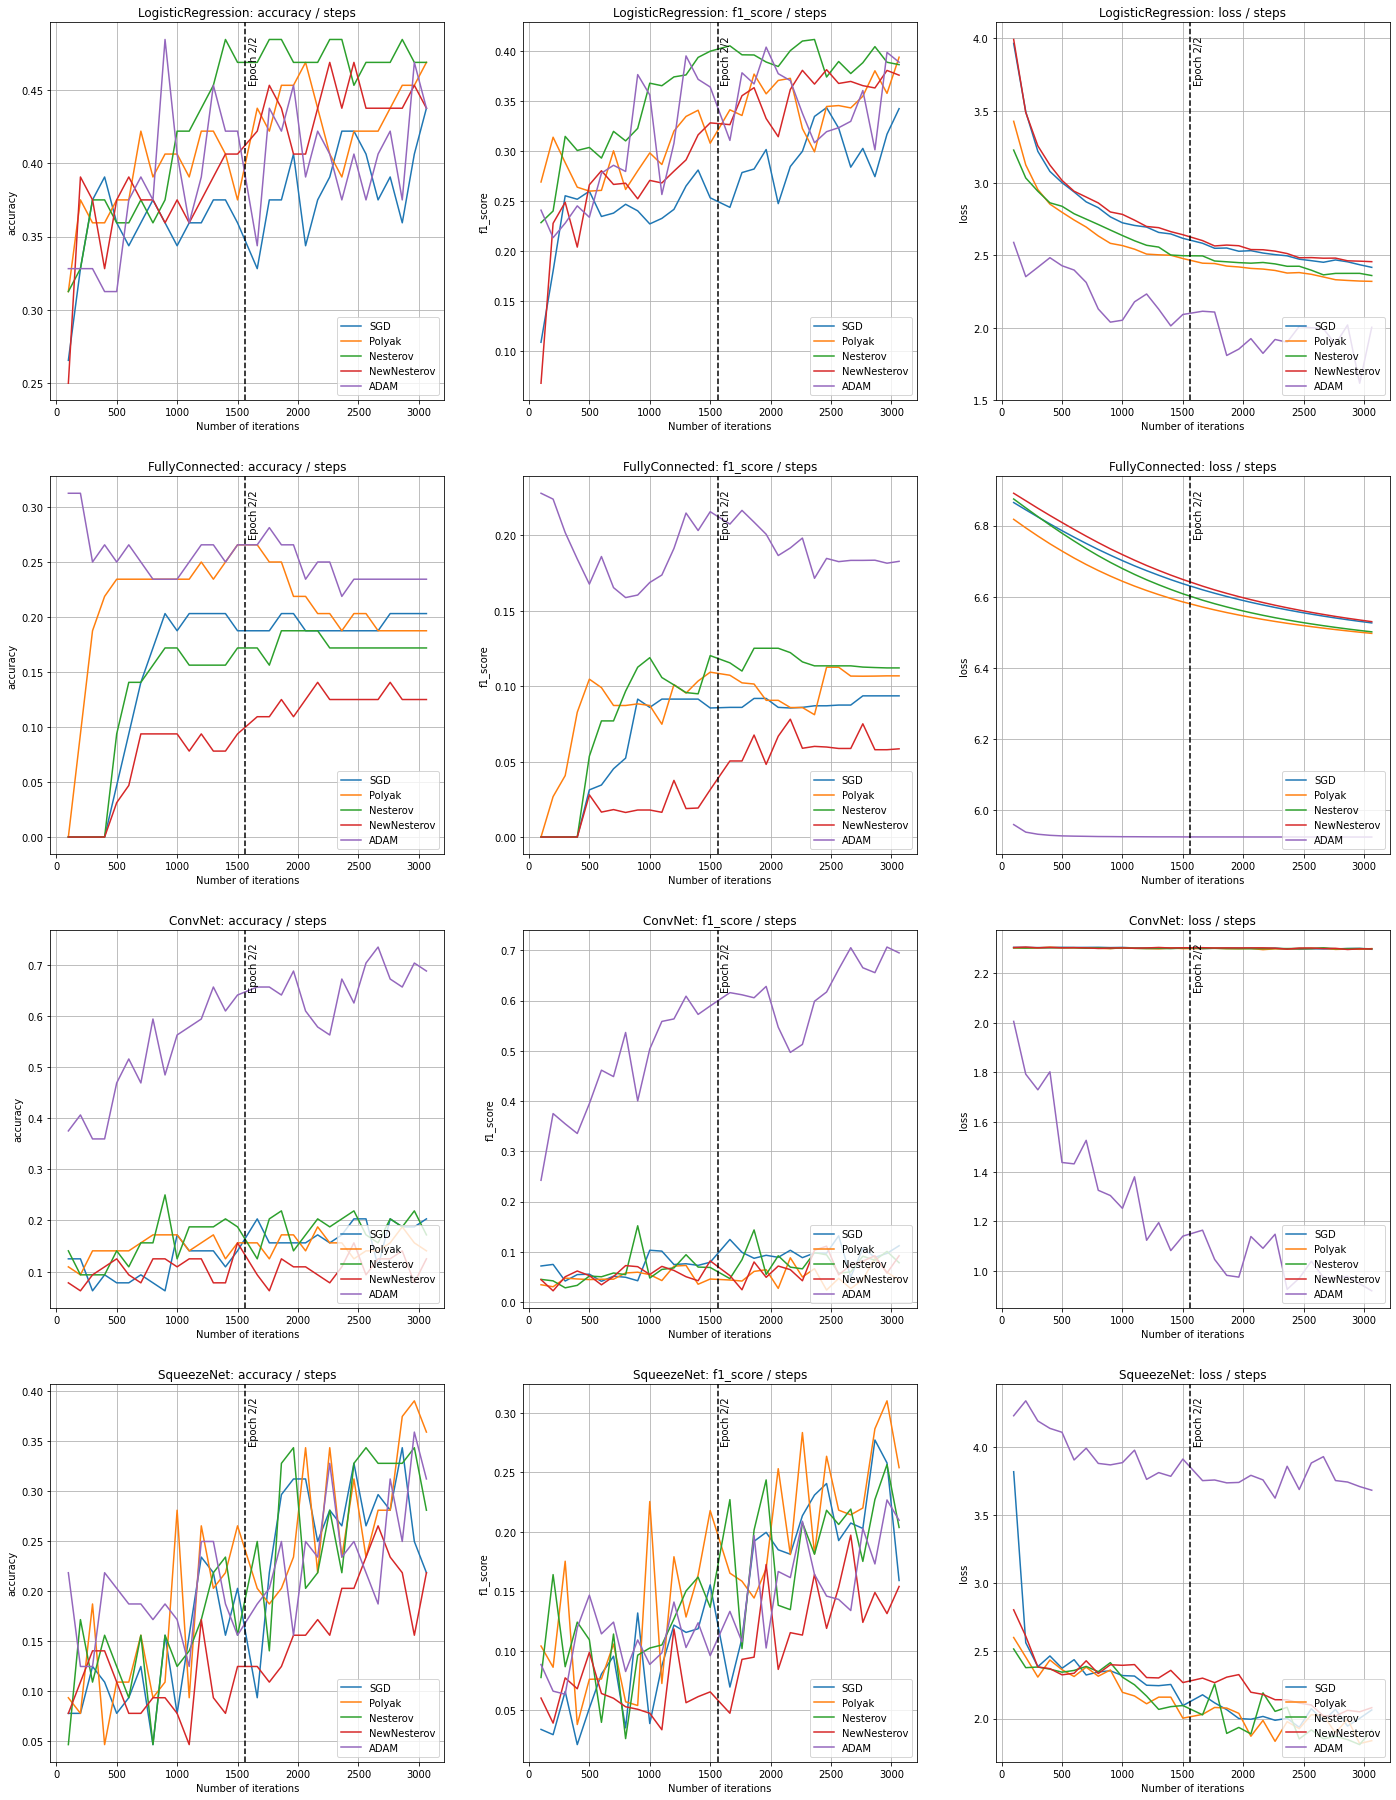

In [0]:
options = {"experiment_options":{"epochs":2}, 'batch_sizes':[256], 'lrs':[0.01], 'momentums':[0.9]}
optimizers = [
    ('SGD', SGDOptimizer, {}),
    ('Polyak', SGDOptimizer, {'momentums': [0.2]}),
    ('Nesterov', SGDOptimizer, {'momentums': [0.2], 'nesterov': 1}),
    ('NewNesterov', NewNesterovOptimizer, {'momentums': [0.2]}),
    ('ADAM', AdamOptimizer, {}),
]

models = [
    ('LogisticRegression', LogisticRegression, {'input_dim': 32 * 32 * 3, 'output_dim': 10}),
    ('FullyConnected', FullyConnected, {'input_dim': 32 * 32 * 3, 'hidden_dim': 128, 'output_dim': 10}),
    ('ConvNet', ConvNet, {'in_ch': 3, 'output_dim': 10}),
    ('SqueezeNet', SqueezeNet, {}),
]

metrics = {
}
steps = []
first_epoch_steps = []

for model_name, model, model_opts in models:
  metrics[model_name] = {
    'accuracy': {},
    'f1_score': {},
    'loss': {},
  }
  for optimizer_name, optimizer, optimizer_opts in optimizers:
    name = model_name + ' + ' + optimizer_name
    print('Start ' + name)
    options['model_options'] = model_opts
    steps, first_epoch_steps, accuracies, f1_scores, losses = run_expirement(model, torch.nn.CrossEntropyLoss, optimizer, options, optimizer_opts)
    for m, res in zip(metrics[model_name], (accuracies, f1_scores, losses)):
      metrics[model_name][m][optimizer_name] = res

show_graphs(steps, first_epoch_steps, metrics)